## Simple Dissipative Chaotic Flow

Refer to Sprott, J. C. "Simplest dissipative chaotic flow." Physics letters A 228, no. 4-5 (1997): 271-274.

A simple algebraic dissipative chaotic flow was found which obeyed the jerk equation:

$\dddot{x} + A \ddot{x} - \dot{x}^{2} + x = 0$

Which can be transformed into a dynamical system of 3 ODE's with A as a parameter as follows:

Let 

$x_{1} = x$ <br>
$x_{2} = \dot{x}$ <br>
$x_{3} = \ddot{x}$ <br>

This implies <br>
$\dot{x_{1}} = x_{2}$ <br>
$\dot{x_{2}} = x_{3}$ <br>
$\dot{x_{3}} = -A x_{3} + x_{2}^{2} - x_{1}$ <br>

I investigate the above dynamical system in this document.

In [1]:
using Plots
using LinearAlgebra

In [2]:
#velocity function for the simple dissipative flow
function velocity(ssp, A)
    x = ssp[1]
    y = ssp[2]
    z = ssp[3]
    # simple dissipative flow equations:
    dxdt = y
    dydt = z
    dzdt = -A*z + y^2 - x
    
    [dxdt; dydt; dzdt]
end

# Stability matrix for the Rossler flow
#    Inputs:
#    ssp: State space vector. dx1 array: ssp = [x, y, z]
#    Outputs:
#    A: Stability matrix evaluated at ssp. dxd NumPy array
#       A[i, j] = del Velocity[i] / del ssp[j]

function StabilityMatrix(ssp, A)
    x = ssp[1]
    y = ssp[2]
    z = ssp[3]
    
    [0 1 0; 
     0  0  1;
     -1  2*y  -A]
end

#RK4 time integration
function rungekutta4(f, x₀, Δt, T) 
   
    # fix up Δt so it evenly divides time interval
    N = convert(Int64, round(T/Δt))
    #Δt = (t₁ - t₀)/N
    Δt2 = Δt/2
    Δt6 = Δt/6
    t = (0:N)*Δt

    x = zeros(N+1, length(x₀))
    x[1,:] = x₀

    for n = 1:N
        xn = x[n,:]
        tn = t[n]
        s1 = f(xn)
        s2 = f(xn + Δt2*s1)
        s3 = f(xn + Δt2*s2)
        s4 = f(xn + Δt *s3)

        x[n+1, :] =  xn + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
    end
    t,x
end

rungekutta4 (generic function with 1 method)

In [3]:
#Parameters:
A = 2.017
f(x) = velocity(x, A)
x₀ = [5; 1.; 0.]
T = 1000.
Δt = 0.01
t,x = rungekutta4(f, x₀, Δt, T)

(0.0:0.01:1000.0, [5.0 1.0 0.0; 5.01 0.999801 -0.0396503; … ; -0.856054 -0.298406 0.452816; -0.859015 -0.293877 0.453132])

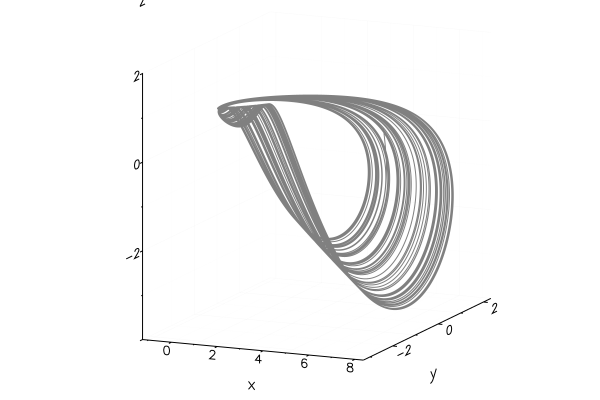

In [4]:
plot!(x[:,1], x[:,2], x[:,3], color=:grey)
plot!(legend=false, xlabel="x", ylabel="y", zlabel="z")

## Poincare section:

We start by defining a Poincare section for the Rossler attractor. For details, refer to chaosbook. 

The idea is as follows: 
* We define a Poincare section plane P by a template point $\hat{x}'$ and a normal vector $\hat{n}$.
* A point $\hat{x}$ is on this plane if U($\hat{x}$) = ($\hat{x}$ - $\hat{x}'$). $\hat{n}$ = 0

We also only want orbits/ trajectories piercing the Poncare section plane P in a specific direction. This is because, we want the first return time of the periodic orbit to be the full period of that orbit.

Therefore, we choose only those $\hat{x}$, such that v($\hat{x}$). $\hat{x}$ > 0 without loss of generality


In [5]:
# Classic Lagrange interpolation function needed for finding the intersection
# of a trajectory with the Poincare section. 

# interpolate y(x) at x = x̂, given vectors of y and x data
function interpolate(y, x, x̂)
    N = length(x)
    ŷ = zero(y[1,:])
    
    for i=1:N
        numer = 1.0;
        denom = 1.0;
        for j=1:N
            if i == j
                continue
            end
            numer *= x̂ - x[j]
            denom *= x[i] - x[j]
        end
        ŷ += y[i,:] * numer/denom
    end
    ŷ
end

interpolate (generic function with 1 method)

In [6]:
# function F integrates x(t) finds the next N intersections with the poincare section h(z) = 0
function F(f, x, Δt, N, h) 
    # find the next N intersections of h(x) = 0 poincare section 
    
    Ntmax = 1000000 # 1000000 # max # of time steps
    Δt2 = Δt/2
    Δt6 = Δt/6
   
    d = length(x)
    # storage for N Poincare intersection values
    X = zeros(N,d)

    # store x(t) and h(t) at five successive time steps
    xseq = zeros(5,d)
    hseq = zeros(5)
    count = 0
    
    for n = 1:Ntmax
        
        if n<=4  # fill in the first four values of x and h
            xseq[n+1,:] = x
            hseq[n+1] = h(x)
        end
        
        s1 = f(x)
        s2 = f(x + Δt2*s1)
        s3 = f(x + Δt2*s2)
        s4 = f(x + Δt *s3)

        x =  x + Δt6*(s1 + 2s2 + 2s3 + s4) # RK4 update formula
        
        if n>=5 
            # shift x and h sequences in time
            xseq[1:4,:] = xseq[2:5,:]
            hseq[1:4] = hseq[2:5]
            
            xseq[5,:] = x
            hseq[5] = h(x)
            
            # if h(t) changes sign, compute Poincare crossing by interpolating x as func of h at h=0
            if hseq[3] < 0 && hseq[4] >= 0
                count += 1
                X[count,:] = interpolate(xseq, hseq, 0.0)                
            end
        end
        
        if count == N
            break
        end
    end
    X
end

F (generic function with 1 method)

In [7]:
#    Rotation matrix about z-axis
#    Input:
#    theta: Rotation angle (radians)
#    Output:
#    Rz: Rotation matrix about z-axis

function zRotation(theta)
    [cos(theta) -sin(theta) 0;
     sin(theta) -cos(theta) 0;
     0          0           1]
end

#Define the Poincare section hyperplane equation
function UPoincare(ssp, sspTemplate, nTemplate)
    dot(ssp-sspTemplate, nTemplate)
end

UPoincare (generic function with 1 method)

In [8]:
# Plot the Poincare intersections along with the x(t) trajectory
#Parameters:
A = 2.017
f(x) = velocity(x, A)

#Set the angle between the Poincare section hyperplane and the x-axis:
thetaPoincare = -pi / 2.0 #

#Define vectors which will be on and orthogonal to the Poincare section hyperplane:
e_x = [1.; 0.; 0.]  # Unit vector in x-direction

#Template vector to define the Poincare section hyperplane:
sspTemplate = zRotation(thetaPoincare) * e_x

#Normal to this plane will be equal to template vector rotated pi/2 about
#the z axis:
nTemplate = zRotation(thetaPoincare + pi/2)*e_x


h(ssp) = UPoincare(ssp, sspTemplate, nTemplate);
sspSolutionPoincare = F(f, x₀, Δt, 1000, h);

plot!(x[:,1], x[:,2], x[:,3], color=:grey)
plot!(legend=false)

plot!(sspSolutionPoincare[:,1], sspSolutionPoincare[:,2], sspSolutionPoincare[:,3], marker=:circ, markersize=2, color=:blue, linecolor=nothing)

In [9]:
#Unit vectors which will span the Poincare section hyperplane are the
#template vector and the unit vector at z. Let us construct a matrix which
#projects state space vectors onto these basis:
e_z = [0.0; 0.0; 1.0] # Unit vector in z direction

ProjPoincare = [(sspTemplate) (e_z) (nTemplate)]
ProjPoincare = transpose(ProjPoincare)

#sspSolutionPoincare has state space vectors on its rows. We act on the
#transpose of this matrix to project each state space point onto Poincare
#basis by a simple matrix multiplication:
#Third column of this matrix should be zero if everything is correct.
PoincareSection = ProjPoincare * transpose(sspSolutionPoincare)
PoincareSection = transpose(PoincareSection)

1000×3 Transpose{Float64,Array{Float64,2}}:
 -0.908493  0.429619  6.21248e-17
 -0.937107  0.450233  6.16911e-17
 -0.892314  0.418129  6.20706e-17
 -0.97309   0.476695  6.10406e-17
 -0.950679  0.46005   6.16369e-17
 -0.892451  0.418206  6.13523e-17
 -0.972791  0.476473  6.12032e-17
 -0.949353  0.459079  6.13116e-17
 -0.891476  0.41752   6.12574e-17
 -0.97502   0.478132  6.07153e-17
 -0.959543  0.466564  6.12303e-17
 -0.905552  0.427473  6.12185e-17
 -0.94344   0.454847  6.11761e-17
  ⋮                              
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        
  0.0       0.0       0.0        

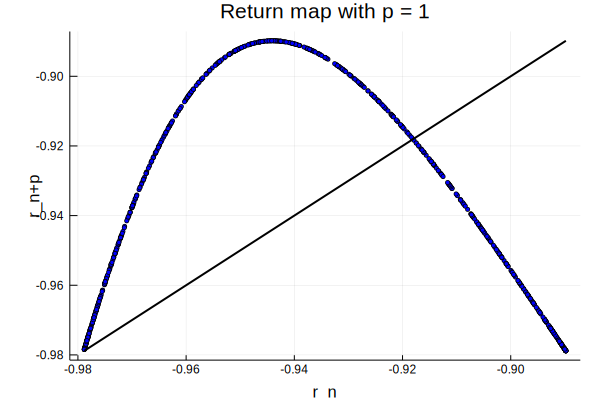

In [10]:
p = 1 # look for period-p orbit via fixed point of pth-iterate return map
N = 800#length(PoincareSection[:, 1])

#PoincareSection intersections according to their radial distance, here, in this section that is just x

rn = PoincareSection[1:N-p, 1]
rnPlusp = PoincareSection[p+1:N, 1]


plot(rn, rnPlusp, marker=:circ, markersize=2, color=:blue, linecolor=nothing)
plot!(rn, rn, linecolor = :black, linewidth = 2)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))

### Find an approximate fixed point of iterated return map

In [11]:
perm = sortperm(abs.(PoincareSection[1:N-p]-PoincareSection[1+p:N]));
@show perm[1:3]
k = perm[1]

perm[1:3] = [346, 22, 697]


346

In [12]:
PoincareSection[k]

-0.9181693703014198

In [13]:
PoincareSection[k+p]

-0.9178804945260239

### Get the corresponding value of (x,y,z) from the time series data

This will serve as an initial guess for our periodic orbit search

In [14]:
xguess = sspSolutionPoincare[k,:]

3-element Array{Float64,1}:
 6.299214622140781e-17
 0.9181693703014198   
 0.4364825752880692   

In [15]:
xguess = sspSolutionPoincare[k+p,:]

3-element Array{Float64,1}:
 6.087795198506107e-17
 0.9178804945260239   
 0.4363413655160453   

In [16]:
h(sspSolutionPoincare[k,:]) #the value of sspSolutionPoincare on the Poincare section
#should be close to zero as it should lie on the section!

1.7598062640401473e-18

In [17]:
@show xguess
F(f, xguess, Δt, p, h) 

xguess = [6.0878e-17, 0.91788, 0.436341]


1×3 Array{Float64,2}:
 6.19622e-17  0.918375  0.436697

### Plot the approximate periodic orbit

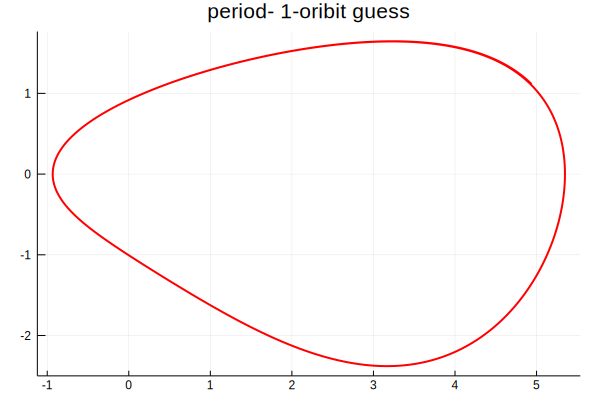

In [18]:
t,xorbguess = rungekutta4(f, xguess, Δt, 15.0);
plot(xorbguess[:,1], xorbguess[:,2], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit guess")

### Use nonlinear solver to refine guess into periodic orbit

In [19]:
using NLsolve
xguess

3-element Array{Float64,1}:
 6.087795198506107e-17
 0.9178804945260239   
 0.4363413655160453   

In [20]:
xguessnext = F(f, xguess, Δt, p, h)

1×3 Array{Float64,2}:
 6.19622e-17  0.918375  0.436697

### Defining the Poincare section another way:
* The Poincare section at this point is given by $h(x) = 0$, which is, in fact $(x-\hat{x}).\hat{n} = 0$, where $x = ssp$, $\hat{x} = sspTemplate$ and $\hat{n} = nTemplate$ in the code.
<br>
We can also define the Poincare section in another way as hz(x) = function(x,y)
<br>
If we denote $\hat{n} = [a, b, c]$ and $\hat{x} = sspTemplate = [\hat{x}, \hat{y}, \hat{z}]$, 
<br>
Then $ h(x) = 0 \Rightarrow a (x-\hat{x}) + b (y - \hat{y}) + c( z - \hat{z}) = 0$
<br>
This can easily be inverted to obtain z as a function of x and y
$z = \hat{z} - \frac{a}{c} (x-\hat{x}) - \frac{b}{c} (x-\hat{x})$
<br>
Caution: this holds ONLY if $c\neq 0$

* However, we have chosen our nTemplate = [1, 0, 0], so the Poincare section is actually the y-z plane or x = 0. Hence we don't need to write a new hz function.

In [21]:
# g(x) = F(x) - x, where F(x) is nth iterate of return map on Poincare section. 
# Thus roots of g(x) == 0 are periodic orbits
function g!(gx, x) 
  
    # compute nth iterate of Poincare map
    X = F(f, [0; x[1]; x[2]], Δt, p, h) 

    # return x,y components of F(x) -x 
    gx .= X[p,2:3] - x
end

g! (generic function with 1 method)

In [22]:
gx = [0.0; 0.0]
g!(gx, xguess[2:3])

2-element Array{Float64,1}:
 0.0004949143121720789
 0.0003554516400096075

In [23]:
soln = nlsolve(g!, xguess[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.91788, 0.436341]
 * Zero: [0.918054, 0.436466]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

In [24]:
xorb₀ = vcat(0, soln.zero)

3-element Array{Float64,1}:
 0.0                
 0.918054280236284  
 0.43646616697142543

In [25]:
h(xorb₀)

-6.123233995736766e-17

In [26]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 6.08237e-17  0.918054  0.436466
 6.10406e-17  0.918054  0.436466
 6.16369e-17  0.918054  0.436466
 6.13116e-17  0.918054  0.436466
 6.21248e-17  0.918054  0.436466
 6.16911e-17  0.918054  0.436466
 6.10812e-17  0.918054  0.436466
 6.12574e-17  0.918054  0.436466
 6.21248e-17  0.918054  0.436466
 6.12032e-17  0.918054  0.436466

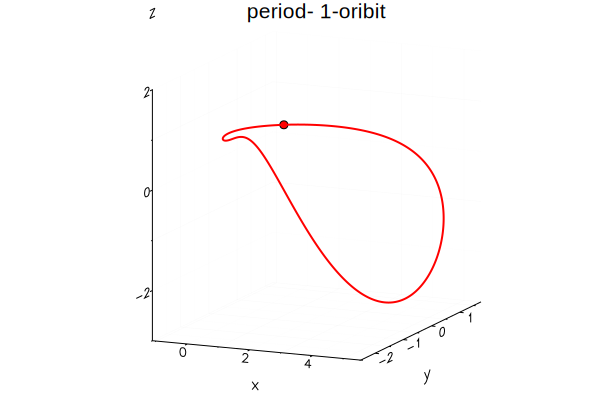

In [27]:
t, xorb = rungekutta4(f, xorb₀, Δt, 15.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

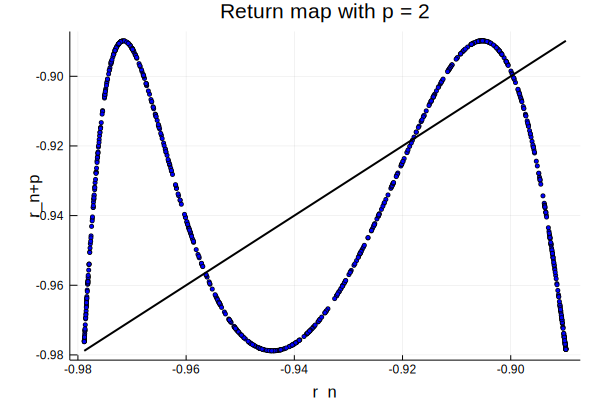

In [28]:
p = 2 # look for period-p orbit via fixed point of pth-iterate return map
N = 800#length(PoincareSection[:, 1])

#PoincareSection intersections according to their radial distance, here, in this section that is just x

rn = PoincareSection[1:N-p, 1]
rnPlusp = PoincareSection[p+1:N, 1]


plot(rn, rnPlusp, marker=:circ, markersize=2, color=:blue, linecolor=nothing)
plot!(rn, rn, linecolor = :black, linewidth = 2)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))

In [29]:
perm = sortperm(abs.(PoincareSection[1:N-p]-PoincareSection[1+p:N]));
@show perm[1:3]
k = perm[2]

perm[1:3] = [346, 775, 347]


775

### Get the corresponding value of (x,y,z) from the time series data

This will serve as an initial guess for our periodic orbit search

In [30]:
xguess = sspSolutionPoincare[k,:]

3-element Array{Float64,1}:
 6.163689350580093e-17
 0.8997039033398959   
 0.4233644071560217   

In [31]:
xguess = sspSolutionPoincare[k+p,:]

3-element Array{Float64,1}:
 6.093216209368535e-17
 0.8994502227484062   
 0.423145134682225    

In [32]:
@show xguess
F(f, xguess, Δt, p, h) 

xguess = [6.09322e-17, 0.89945, 0.423145]


2×3 Array{Float64,2}:
 6.15827e-17  0.95692   0.46473 
 6.13116e-17  0.900469  0.423866

In [33]:
gx = [0.0; 0.0]
g!(gx, xguess[2:3])
soln = nlsolve(g!, xguess[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.89945, 0.423145]
 * Zero: [0.89966, 0.423294]
 * Inf-norm of residuals: 0.000000
 * Iterations: 2
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 3
 * Jacobian Calls (df/dx): 3

In [34]:
xorb₀ = vcat(0, soln.zero)

3-element Array{Float64,1}:
 0.0                
 0.8996602860869125 
 0.42329382147618844

In [35]:
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 6.19079e-17  0.956449  0.464383
 6.08237e-17  0.89966   0.423294
 6.12574e-17  0.956449  0.464383
 6.14743e-17  0.89966   0.423294
 6.10948e-17  0.956449  0.464383
 6.28837e-17  0.89966   0.423294
 6.13658e-17  0.956449  0.464383
 6.13116e-17  0.89966   0.423294
 6.06611e-17  0.956449  0.464383
 6.11897e-17  0.899661  0.423294

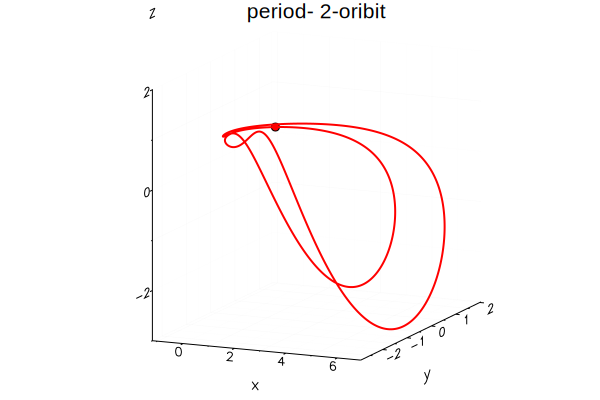

In [36]:
t, xorb = rungekutta4(f, xorb₀, Δt, 25.0)

plot([xorb₀[1]], [xorb₀[2]], [xorb₀[3]], marker=:circ, color=:red, linewidth=3)
plot!(xorb[:,1], xorb[:,2], xorb[:,3], color=:red, linewidth=2)
plot!(legend = false, title = "period- "*string(p)*"-oribit")
plot!(xlabel="x",ylabel="y", zlabel="z")

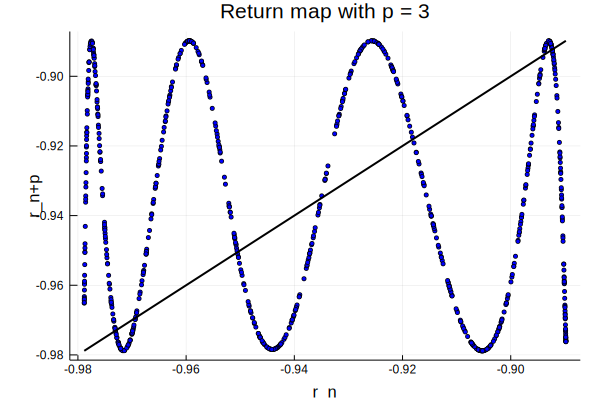

In [37]:
p = 3 # look for period-p orbit via fixed point of pth-iterate return map
N = 800#length(PoincareSection[:, 1])

#PoincareSection intersections according to their radial distance, here, in this section that is just x

rn = PoincareSection[1:N-p, 1]
rnPlusp = PoincareSection[p+1:N, 1]


plot(rn, rnPlusp, marker=:circ, markersize=2, color=:blue, linecolor=nothing)
plot!(rn, rn, linecolor = :black, linewidth = 2)

plot!(xlabel="r_n", ylabel="r_n+p", legend=false)

plot!(title = "Return map with p = " * string(p))

In [38]:
perm = sortperm(abs.(PoincareSection[1:N-p]-PoincareSection[1+p:N]));
@show perm[1:5]
k1 = perm[1]
k2 = perm[4]
k3 = perm[5]

perm[1:5] = [228, 250, 3, 767, 4]


4

In [39]:
xguess1 = sspSolutionPoincare[k1,:]

3-element Array{Float64,1}:
 6.16911036144252e-17
 0.9730774671621504  
 0.47658143243177975 

In [40]:
xguess1 = sspSolutionPoincare[k1+p,:]

3-element Array{Float64,1}:
 6.066111155056397e-17
 0.9731613138830534   
 0.47674845196808074  

In [41]:
xguess2 = sspSolutionPoincare[k2,:]

3-element Array{Float64,1}:
 6.098637220230962e-17
 0.9693306756303869   
 0.47379960689070333  

In [42]:
xguess2 = sspSolutionPoincare[k2+p,:]

3-element Array{Float64,1}:
 6.21247844834194e-17
 0.9691399411764869  
 0.47376116254258627 

In [43]:
xguess3 = sspSolutionPoincare[k3,:]

3-element Array{Float64,1}:
 6.10405823109339e-17
 0.973089963679533   
 0.47669538393869004 

In [44]:
xguess3 = sspSolutionPoincare[k3+p,:]

3-element Array{Float64,1}:
 6.120321263680673e-17
 0.9727906772378527   
 0.4764728098192968   

In [45]:
gx = [0.0; 0.0]
g!(gx, xguess1[2:3])
soln = nlsolve(g!, xguess1[2:3])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.973161, 0.476748]
 * Zero: [0.973058, 0.476671]
 * Inf-norm of residuals: 0.000000
 * Iterations: 3
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 4
 * Jacobian Calls (df/dx): 4

In [46]:
xorb₀ = vcat(0, soln.zero)
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 6.10948e-17  0.950535  0.459945
 6.12134e-17  0.892335  0.418123
 6.09322e-17  0.973058  0.476671
 6.13116e-17  0.950535  0.459945
 6.14201e-17  0.892335  0.418123
 6.12574e-17  0.973058  0.476671
 6.0878e-17   0.950535  0.459945
 6.15827e-17  0.892335  0.418123
 6.17453e-17  0.973058  0.476671
 6.20164e-17  0.950535  0.459945

In [47]:
gx = [0.0; 0.0]
g!(gx, xguess2[2:3])
soln = nlsolve(g!, xguess2[2:3])
xorb₀ = vcat(0, soln.zero)
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 6.09322e-17  0.935031  0.448643
 6.1149e-17   0.893963  0.419296
 6.12981e-17  0.969322  0.473897
 6.13387e-17  0.935031  0.448643
 6.14743e-17  0.893963  0.419296
 6.13929e-17  0.969322  0.473897
 6.12574e-17  0.935031  0.448643
 6.1149e-17   0.893963  0.419296
 6.1149e-17   0.969322  0.473897
 6.11693e-17  0.935031  0.448643

In [48]:
gx = [0.0; 0.0]
g!(gx, xguess2[2:3])
soln = nlsolve(g!, xguess2[2:3])
xorb₀ = vcat(0, soln.zero)
F(f, xorb₀, Δt, 10, h)

10×3 Array{Float64,2}:
 6.09322e-17  0.935031  0.448643
 6.1149e-17   0.893963  0.419296
 6.12981e-17  0.969322  0.473897
 6.13387e-17  0.935031  0.448643
 6.14743e-17  0.893963  0.419296
 6.13929e-17  0.969322  0.473897
 6.12574e-17  0.935031  0.448643
 6.1149e-17   0.893963  0.419296
 6.1149e-17   0.969322  0.473897
 6.11693e-17  0.935031  0.448643